## 1.实验准备

In [1]:
pip install jieba

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


## 2.数据载入与预处理

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import jieba
import re
data = pd.read_csv("D:/jupyter file/date/news.csv")
data.head()

,text,label
0,\n 汽车行业\n 越来越多的人成为“购车族”，汽车消费也在百姓消费额中所占比重越来越大...,Culture
1,“新异之见”和“常识之见”\n 记者：在给陈村的信中，你把张炜的《精神的背景》视为坏文章，...,Culture
2,\n 风暴是一波未平，一波又起。“胡风分子”的嫌疑刚刚排除，一项更大更严重的政治嫌疑又降临...,Culture
3,一个在中国学习和工作过、现驻印度德里的英国《经济学人》记者西蒙・朗(Simon Long...,Culture
4,&nbsp; 俯视罗布沙漠中的小河墓地（３月１７日摄）。由新疆文物考古研究所所长伊弟利斯・...,Culture


## 查看文本数据的过程中, 发现文本中存在很多问题。需要不断优化、修正文本处理函数。

In [7]:
# 根据分词结果, 人为添加新的停用词。优化分词效果
stopwords = [" ", "\n", "\t"]
with open("D:/jupyter file/date/ChineseStopwords.txt", "r", encoding="utf-8") as f:
    for line in f:
        stopwords.append(line.strip("\n"))

## 以下为文本处理过程中发现的问题及对应预处理函数。

In [10]:
# 经过数据查看发现, 很多文档的为全角字符，需要转换
def Q2B(uchar):
    """单个字符 全角转半角"""
    inside_code = ord(uchar)
    if inside_code == 0x3000: # 除了空格其他的全角半角的公式为: 半角 = 全角 - 0xfee0
        inside_code = 0x0020
    else:
        inside_code -= 0xfee0
    if inside_code < 0x0020 or inside_code > 0x7e: #转完之后不是半角字符返回原来的字符
        return uchar
    return chr(inside_code)

def stringQ2B(ustring):
    """把字符串全角转半角"""
    return "".join([Q2B(uchar) for uchar in ustring])

# 文本中发现很多日期
# jieba分词无法识别日期，需要人为提取
def extract_date(text):
    ymd = re.compile("\d{2,4}年1{0,1}\d{1}月[123]{0,1}\d{1}日{0,1}")
    ym = re.compile("\d{2,4}年1{0,1}\d{1}月")
    y = re.compile("\d{2,4}年")
    m = re.compile("1{0,1}\d{1}月")
    d = re.compile("[123]{0,1}\d{1}日")
    md = re.compile("1{0,1}\d{1}月[123]{0,1}\d{1}日")
    date = []
    for regx in [ymd, ym, y, md, m, d]:
        date.extend(re.findall(regx, text))
        text = re.sub(regx, "", text)
        return text,date

# 文本中包含很多HTML无意义字符，如&nbsp;
# 将这些符号当成停用词去掉
def extract_symbol(text):
    syms = []
    sym = re.compile("&\w{1,6};")
    text = re.sub(sym, "", text)
    return text


## 定义preprocessing函数, 将预处理过程整合到一起

In [11]:
# 数据预处理与分词
def preprocessing(text):
    text = stringQ2B(text)
    text, date = extract_date(text)
    text = extract_symbol(text)
    words = jieba.cut(text)
 # 将提取到的日期添加到分词结果中
    return [w for w in words if w not in stopwords] + date

## 对data中的文本进行预处理, 分词结果赋予到data的words列。

In [12]:
data['words'] = data.text.apply(preprocessing)
data.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Windows\Temp\jieba.cache
Loading model cost 0.661 seconds.
Prefix dict has been built successfully.


,text,label,words
0,\n 汽车行业\n 越来越多的人成为“购车族”，汽车消费也在百姓消费额中所占比重越来越大...,Culture,"[汽车行业, 越来越, 成为, 购车族, 汽车, 消费, 百姓, 消费额, 中所, 占, 比..."
1,“新异之见”和“常识之见”\n 记者：在给陈村的信中，你把张炜的《精神的背景》视为坏文章，...,Culture,"[新异, 之见, 常识, 之见, 记者, 陈村, 信中, 张炜, 精神, 背景, 视为, 坏..."
2,\n 风暴是一波未平，一波又起。“胡风分子”的嫌疑刚刚排除，一项更大更严重的政治嫌疑又降临...,Culture,"[风暴, 一波未平, 一波又起, 胡风, 分子, 嫌疑, 刚刚, 排除, 一项, 更大, 更..."
3,一个在中国学习和工作过、现驻印度德里的英国《经济学人》记者西蒙・朗(Simon Long...,Culture,"[中国, 学习, 工作, 现驻, 印度, 德里, 英国, 经济学, 记者, 西蒙, ・, 朗..."
4,&nbsp; 俯视罗布沙漠中的小河墓地（３月１７日摄）。由新疆文物考古研究所所长伊弟利斯・...,Culture,"[俯视, 罗布, 沙漠, 中, 小河, 墓地, 月, 17, 日摄, 新疆文物考古研究所, ..."


## 我们使用sklearn的CountVectorizer()生成词向量。 CountVectorizer()使用空格对文本进行分词统计, 因此需要生成空格分割的文本corpus列

In [15]:
data["corpus"] = data.words.apply(lambda x: " ".join(x))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = CountVectorizer()
bow = vec.fit_transform(data["corpus"])

## 使用dataframe简单了解创建的文本特征

In [16]:
bow_df = pd.DataFrame(bow.toarray(),
                 columns=vec.get_feature_names())
bow_df.head()

c:\users\king\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000000,000002,000004,000005,000007,000009,000022,000025,...,龙脊,龙舌兰,龙船,龙门,龙骨,龚伟,龚在,龚建仁,龚建国,龚晓犁
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 使用KMeans算法对文本进行聚类。 使用silhouette_score评估不同K值的聚类效果。
silhouette_score为聚类算法中，评估聚类凝聚程度的轮廓系数,取值范围[-1, 1], 系数越大，聚类效果越好。


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
 
for i in range(3, 10):
    km = KMeans(n_clusters=i,
             init="k-means++",
             max_iter=100,
             n_init=1)
    km.fit(bow.toarray())
    score = silhouette_score(bow.toarray(),
                              km.labels_,
                              metric="euclidean",
                              sample_size=len(data)//2)
    print(f"K = {i}: {score:.3f}")

K = 3: 0.710
K = 4: -0.059
K = 5: 0.170
K = 6: 0.475
K = 7: 0.677
K = 8: 0.568
K = 9: 0.686


## 查看分为9个类别时的聚类效果

In [18]:
print(data.label.unique())
km = KMeans(n_clusters=9,
         init="k-means++",
         max_iter=100,
         n_init=1)
km.fit(bow.toarray())
 
 # 对质心点的特征排序
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
 
 # 查看不同聚类的质心特征构成
terms = vec.get_feature_names()
for i in range(9):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

['Culture' 'Education' 'Finance' 'Health' 'IT' 'Military' 'Recruit'
 'Sports' 'Travel']
Cluster 0: nbsp 公司 奥美定 2005 富华 上市 产品 中国 审议 上市公司
Cluster 1: nbsp 公司 审议 行情 论坛 2005 股东 年度 议案 股份
Cluster 2: 医院 记者 患者 透析 病人 陕西省 核工业 二一五 姬海涛 信息
Cluster 3: 中国 公司 工作 问题 已经 进行 发展 市场 美国 学生
Cluster 4: 轻骑兵 突厥 具装 骑兵 军队 发展 机动性 甲骑 主要 装备
Cluster 5: nbsp 投票 股东 会议 公司 网络 董事会 相关 流通股 委托
Cluster 6: 招生 专业 录取 考生 考试 要求 艺术类 体育 计划 院校
Cluster 7: nbsp 公司 股东 股权 股份 应为 情况 流通股 调整 改革方案
Cluster 8: 司马 羊献容 贾南风 皇后 皇帝 刘曜 匈奴 司马炎 已经 司马伦


c:\users\king\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 查看聚类效果


In [19]:
data["label1"] = km.labels_
data.groupby('label1').label.count()

label1
0     24
1      1
2      1
3    864
4      1
5      1
6      2
7      5
8      1
Name: label, dtype: int64

## 从结果可以看到，绝大多数新闻都被聚类归类到某一类别, 聚类效果并不理想

In [20]:
data.groupby(['label', 'label1']).label.count()

label      label1
Culture    3          99
           8           1
Education  3          98
           6           2
Finance    0          23
           1           1
           3          70
           5           1
           7           5
Health     0           1
           2           1
           3          98
IT         3         100
Military   3          99
           4           1
Recruit    3         100
Sports     3         100
Travel     3         100
Name: label, dtype: int64

## 3.基于tfidf向量聚类(Pipeline)

In [21]:
# 将查看效果的代码定义成函数，方便后续使用
def describe_cluster(order_center, feature_names):
    for i in range(9):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()
 
def describe_label(data, label):
    print(data.groupby(label).label.count())
    print()
    print(data.groupby([label, 'label']).label.count())
    print()

## 使用Pipeline生成数据处理


In [22]:
from sklearn.pipeline import Pipeline
pipe1 = Pipeline([('tfidf', TfidfVectorizer()),
                  ('kmeans', KMeans(n_clusters=9,
                                 init="k-means++",
                                 max_iter=100,
                                 n_init=1)),
                  ])
pipe1.fit(data['corpus'])
order_centroids = pipe1[1].cluster_centers_.argsort()[:, ::-1]
feature_names = pipe1[0].get_feature_names()
describe_cluster(order_centroids, feature_names)

Cluster 0: 食物 患者 物质 引起 摄入 过敏 疾病 维生素 食品 皮肤
Cluster 1: nbsp 公司 股份 股东 审议 股权 有限公司 议案 董事会 上市公司
Cluster 2: 旅游 文化 旅行社 游客 中国 乡村 活动 黄金周 五一 博物馆
Cluster 3: 比赛 队员 新华社 球队 冠军 联赛 主场 申花 球员 决赛
Cluster 4: 考生 招生 考试 专业 录取 志愿 高校 报名 学校 计划
Cluster 5: 中国 美国 训练 导弹 印度 系统 飞机 俄罗斯 公司 索尼
Cluster 6: 工作 孩子 公司 学生 企业 中国 问题 生活 现在 就业
Cluster 7: 手机 移动 资费 北京 to 套餐 石家庄 millicom 用户 the
Cluster 8: 市场 公司 证券 机构 行情 产品 医院 增长 药物 目前


c:\users\king\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
data['label2'] = pipe1.predict(data['corpus'])
describe_label(data, "label2")

label2
0     34
1     39
2     81
3     86
4     32
5    129
6    324
7     44
8    131
Name: label, dtype: int64

label2  label    
0       Culture       1
        Education     2
        Health       21
        IT            3
        Military      3
        Recruit       2
        Travel        2
1       Finance      39
2       Culture       8
        Education     3
        Finance       1
        Health        1
        IT            2
        Military      1
        Sports        1
        Travel       64
3       IT            1
        Sports       85
4       Education    32
5       Culture      11
        Education     3
        Finance       2
        Health        2
        IT           27
        Military     74
        Recruit       5
        Travel        5
6       Culture      71
        Education    57
        Finance       8
        Health       39
        IT           20
        Military     15
        Recruit      92
        Sports        6
        Travel       16
7  

## 4.TFIDF+层次聚类

In [24]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.base import TransformerMixin
 
# 自定义转换器。
# fit函数不做任何动作，transform函数将矩阵转换成密集矩阵
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()
 
pipe3 = Pipeline([('tfidf', TfidfVectorizer()),
                  ('todense', DenseTransformer()),
                  ('all_cluster', AgglomerativeClustering(n_clusters=9,
                                 linkage='ward',
                                 compute_distances=True,
                                 connectivity=None)),
                  ])
label = pipe3.fit_predict(data['corpus'])
data['label4'] = label
describe_label(data, 'label4')

c:\users\king\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


label4
0    107
1     95
2    504
3     36
4     81
5     10
6     15
7     36
8     16
Name: label, dtype: int64

label4  label    
0       Culture       2
        Education    52
        Finance       1
        Health        6
        IT            4
        Recruit      40
        Sports        1
        Travel        1
1       Culture      19
        Education     1
        Military     69
        Travel        6
2       Culture      79
        Education    25
        Finance      28
        Health       91
        IT           93
        Military     29
        Recruit      57
        Sports       10
        Travel       92
3       Finance      35
        IT            1
4       Education     1
        IT            2
        Military      1
        Recruit       2
        Sports       74
        Travel        1
5       Education     6
        Health        3
        Recruit       1
6       Education    15
7       Finance      36
8       Military      1
        Sports       15
Nam

## tfidf的层次聚类效果并不理想。 不过层次聚类方便可视化理解聚类效果，我们可以画出层次图，查看聚类构成。

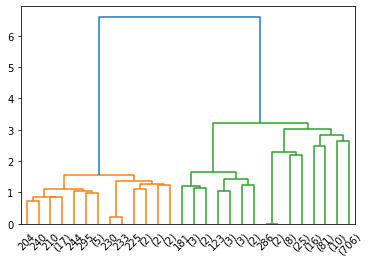

In [25]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
 
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
 
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)
plot_dendrogram(pipe3[-1], truncate_mode='level', p=4) # p值决定了层次的高度